In [8]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.utils import resample, shuffle

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV

from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

In [11]:
data = pd.read_csv('C:/Users/OneDrive/Desktop/line_dataset.csv')
data.head(5)

,x1,x2,x3,x4,x5,z1,z2,z3,z4,y
0,0.717418,0.795423,0.863755,0.238975,-0.580673,0.876079,-0.540210,0.282392,-0.240825,3.646185
1,0.279943,0.247098,0.185882,0.406642,-0.127494,0.610114,0.808972,0.486580,0.170917,1.368708
2,0.577578,0.731462,0.601269,0.782388,0.011900,-0.063923,-0.252456,0.322269,0.338669,2.756800
3,-0.849701,-0.744982,-0.865722,-0.412587,0.573294,-0.230305,-0.992638,-0.540978,-0.757145,-4.345624
4,-0.071554,0.048458,-0.074043,0.270613,-0.157298,-0.235974,0.017538,-0.076862,0.459071,0.589266


In [12]:
data.dtypes

x1    float64
x2    float64
x3    float64
x4    float64
x5    float64
z1    float64
z2    float64
z3    float64
z4    float64
y     float64
dtype: object

In [13]:
X = data.drop('y', axis=1)
y = data['y']

In [14]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Lasso

In [15]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with the original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Lasso Regression with cross-validation to find the best alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

# Predicting on test set
y_pred = lasso.predict(X_test_scaled)

# Identifying significant (non-zero coefficients) and non-significant (zero coefficients) features
significant_features = X.columns[lasso.coef_ != 0]
non_significant_features = X.columns[lasso.coef_ == 0]

print(lasso.coef_)

significant_features.tolist(), non_significant_features.tolist()

[1.15801042 0.88380097 0.56330707 0.17769625 0.1656273  0.00120961
 0.00331065 0.00255161 0.00462927]


(['x1', 'x2', 'x3', 'x4', 'x5', 'z1', 'z2', 'z3', 'z4'], [])

### Permutation Test

In [16]:
# Identify significant and non-significant variables based on a coefficient threshold
threshold = 0.01
lasso_significant_vars = X.columns[lasso.coef_ >= threshold]  # Adjusted to identify non-zero coefficients as significant
lasso_nonsignificant_vars = X.columns[lasso.coef_ < threshold]  # Adjusted for zero coefficients as non-significant

# Initialize error counters
type_1_errors = {var: 0 for var in lasso_nonsignificant_vars}
type_2_errors = {var: 0 for var in lasso_significant_vars}
n_permutations = 1000

# Perform the restricted permutation test
for _ in range(n_permutations):
    # Permute the non-significant component
    X_permuted = X[lasso_nonsignificant_vars].sample(frac=1).reset_index(drop=True)
    X_combined = pd.concat([X[lasso_significant_vars], X_permuted], axis=1)
    # Standardize the permuted dataset
    #X_permuted_scaled = scaler.transform(X_permuted)

    # Fit the model on the combined dataset
    lasso.fit(X_combined, y)

    # Update error counts
    for var in lasso_nonsignificant_vars:
        if lasso.coef_[X_combined.columns.get_loc(var)] != 0:
            type_1_errors[var] += 1  # False positive
    for var in lasso_significant_vars:
        if lasso.coef_[X_combined.columns.get_loc(var)] == 0:
            type_2_errors[var] += 1  # False negative

# Calculate error rates
lasso_error_rates = {}
for var in lasso_nonsignificant_vars:
    lasso_error_rates[var] = {'Type 1 Error Rate (%)': type_1_errors[var] / n_permutations * 100}
for var in lasso_significant_vars:
    lasso_error_rates[var] = {'Type 2 Error Rate (%)': type_2_errors[var] / n_permutations * 100}

lasso_error_rates

{'z1': {'Type 1 Error Rate (%)': 10.6},
 'z2': {'Type 1 Error Rate (%)': 8.799999999999999},
 'z3': {'Type 1 Error Rate (%)': 9.700000000000001},
 'z4': {'Type 1 Error Rate (%)': 10.2},
 'x1': {'Type 2 Error Rate (%)': 0.0},
 'x2': {'Type 2 Error Rate (%)': 0.0},
 'x3': {'Type 2 Error Rate (%)': 0.0},
 'x4': {'Type 2 Error Rate (%)': 0.0},
 'x5': {'Type 2 Error Rate (%)': 0.0}}

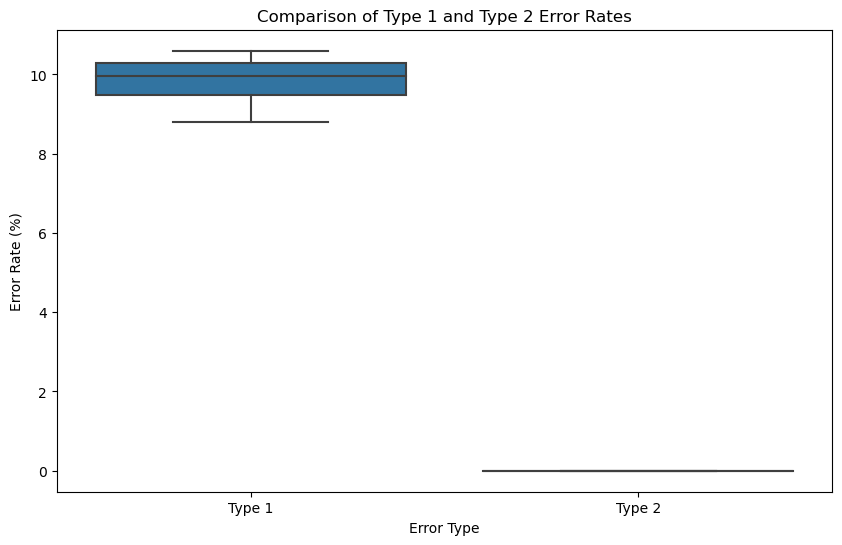

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

data = {'Variable': [], 'Error Rate (%)': [], 'Error Type': []}
for var, errors in lasso_error_rates.items():
    for error_type, rate in errors.items():
        data['Variable'].append(var)
        data['Error Rate (%)'].append(rate)
        data['Error Type'].append('Type 1' if 'Type 1' in error_type else 'Type 2')

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Error Type', y='Error Rate (%)', data=df)
plt.title('Comparison of Type 1 and Type 2 Error Rates')
plt.xlabel('Error Type')
plt.ylabel('Error Rate (%)')
plt.show()

In [18]:
lasso_nonsignificant_vars

Index(['z1', 'z2', 'z3', 'z4'], dtype='object')

### Bootstrapping

In [19]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Assuming X_train_scaled, y_train are your training predictors and response
# And X, y are the full dataset for reference

np.random.seed(42)  # For reproducibility
n_bootstraps = 1000  # Adjust as necessary for your computational resources

# Initial LASSO fit is already provided in your setup
# Calculate initial residuals
y_train_pred = lasso.predict(X_train_scaled)  # Ensure this uses the training set
initial_residuals = y_train - y_train_pred

# Containers for bootstrap error tracking
bootstrap_type_1_errors = np.zeros(len(lasso_nonsignificant_vars))
bootstrap_type_2_errors = np.zeros(len(lasso_significant_vars))

for i in range(n_bootstraps):
    # Resample residuals and create a new bootstrap target
    resampled_residuals = np.random.choice(initial_residuals, size=len(initial_residuals), replace=True)
    y_bootstrap = y_train_pred + resampled_residuals
    
    # Fit a new LASSO model to the original X_train_scaled with the bootstrap target
    lasso_boot = Lasso(alpha=lasso.alpha_)  # Reuse the alpha from the initial fit
    lasso_boot.fit(X_train_scaled, y_bootstrap)
    
    # Identify significant and non-significant variables based on the bootstrap model
    boot_significant_vars = X.columns[lasso_boot.coef_ >= threshold]
    boot_nonsignificant_vars = X.columns[lasso_boot.coef_ < threshold]
    
    # Update Type 1 and Type 2 error counts
    # Type 1: Count how many times non-significant vars are incorrectly identified as significant
    bootstrap_type_1_errors += np.isin(lasso_nonsignificant_vars, boot_significant_vars).astype(int)
    
    # Type 2: Count how many times significant vars are incorrectly identified as non-significant
    bootstrap_type_2_errors += np.isin(lasso_significant_vars, boot_nonsignificant_vars).astype(int)

# Calculate error rates
type_1_error_rate = bootstrap_type_1_errors / n_bootstraps * 100
type_2_error_rate = bootstrap_type_2_errors / n_bootstraps * 100

# Mapping back to variables for reporting
type_1_errors_report = dict(zip(lasso_nonsignificant_vars, type_1_error_rate))
type_2_errors_report = dict(zip(lasso_significant_vars, type_2_error_rate))

print("Type 1 Error Rates:", type_1_errors_report)
print("Type 2 Error Rates:", type_2_errors_report)


Type 1 Error Rates: {'z1': 5.6000000000000005, 'z2': 5.8999999999999995, 'z3': 5.2, 'z4': 3.0}
Type 2 Error Rates: {'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0}


### Forward Selection

In [20]:
# Function to perform forward selection
def forward_selection(X, y):
    selected_features = []
    remaining_features = list(X.columns)

    while remaining_features:
        best_pvalue = np.inf
        next_feature = None
        
        for feature in remaining_features:
            #model_features = selected_features + [feature]
            X_subset = sm.add_constant(X[selected_features + [feature]])
            model = sm.OLS(y, X_subset).fit()
            pvalue = model.pvalues[feature]

            # Check if the p-value is significant and lower than the best found so far
            if pvalue < best_pvalue:
                best_pvalue = pvalue
                next_feature = feature
        
        # If the next best feature is significant, add it to the selected features
        if next_feature and best_pvalue < 0.05:  # Assuming 0.05 significance level
            selected_features.append(next_feature)
            remaining_features.remove(next_feature)
        else:
            break

    return selected_features, model

# Perform forward selection
selected_features_forward, ffmodel = forward_selection(X, y)

# Print the selected features
print("Selected Features from Forward Selection:", selected_features_forward)
#print("Model Summary:", ffmodel.summary())

Selected Features from Forward Selection: ['x1', 'x2', 'x3', 'x4', 'x5', 'z4', 'z3', 'z2', 'z1']


In [21]:
ffX_selected = X[selected_features_forward]
ffX_selected = sm.add_constant(ffX_selected)  # Add constant term for intercept
ff_ols_model = sm.OLS(y, ffX_selected).fit()

for feature, coef in zip(ffX_selected.columns[1:], ffmodel.params[1:]):
    print(f"{feature}: {coef}")

x1: 2.0134591974437637
x2: 1.496403316504273
x3: 0.9957854967436931
x4: 0.5004114575228589
x5: 0.5098942555136339
z4: 0.01207402149665408
z3: 0.01077436399299594
z2: 0.010633726686923275
z1: 0.006838812522357165


### Permutation Test for Forward Selection

In [22]:
# Set the coefficient threshold
coefficient_threshold = 0.01

# Identify significant and non-significant variables based on the coefficient threshold
ffsignificant_vars = [var for var in selected_features_forward if ff_ols_model.params[var] > coefficient_threshold]
ffnonsignificant_vars = [var for var in selected_features_forward if ff_ols_model.params[var] <= coefficient_threshold]

# Initialize error counters
type_1_errors = {var: 0 for var in ffnonsignificant_vars}
type_2_errors = {var: 0 for var in ffsignificant_vars}
n_permutations = 1000

# Perform the restricted permutation test
for _ in range(n_permutations):
    # Permute the non-significant component
    X_permuted = X[ffnonsignificant_vars].sample(frac=1).reset_index(drop=True)
    X_combined = pd.concat([X[ffsignificant_vars], X_permuted], axis=1)
    
    # Fit the model on the combined dataset
    ols_model_combined = sm.OLS(y, sm.add_constant(X_combined)).fit()

    # Update error counts
    for var in ffnonsignificant_vars:
        if ols_model_combined.pvalues[var] < 0.05:
            type_1_errors[var] += 1  # False positive
    for var in ffsignificant_vars:
        if ols_model_combined.pvalues[var] >= 0.05:
            type_2_errors[var] += 1  # False negative

# Calculate error rates
fferror_rates = {}
for var in ffnonsignificant_vars:
    fferror_rates[var] = {'Type 1 Error Rate (%)': type_1_errors[var] / n_permutations * 100}
for var in ffsignificant_vars:
    fferror_rates[var] = {'Type 2 Error Rate (%)': type_2_errors[var] / n_permutations * 100}

fferror_rates

{'z1': {'Type 1 Error Rate (%)': 5.1},
 'x1': {'Type 2 Error Rate (%)': 0.0},
 'x2': {'Type 2 Error Rate (%)': 0.0},
 'x3': {'Type 2 Error Rate (%)': 0.0},
 'x4': {'Type 2 Error Rate (%)': 0.0},
 'x5': {'Type 2 Error Rate (%)': 0.0},
 'z4': {'Type 2 Error Rate (%)': 0.0},
 'z3': {'Type 2 Error Rate (%)': 0.0},
 'z2': {'Type 2 Error Rate (%)': 0.0}}

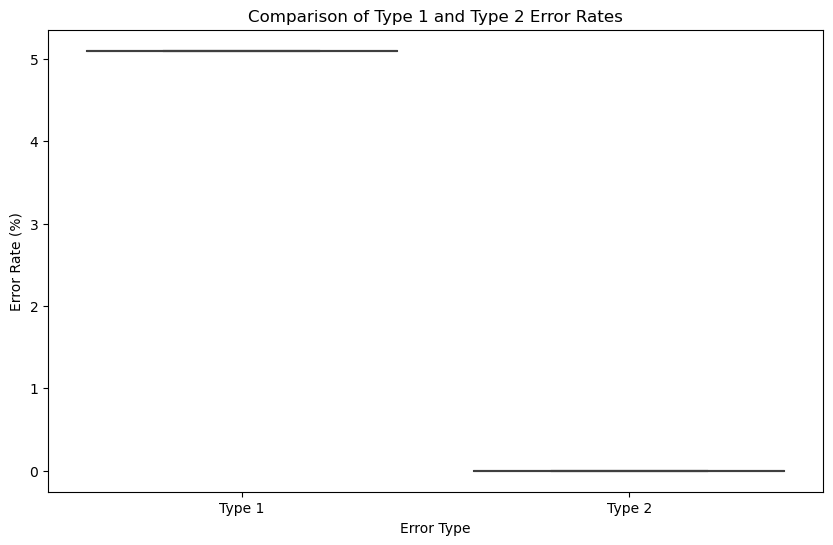

In [23]:
data = {'Variable': [], 'Error Rate (%)': [], 'Error Type': []}
for var, errors in fferror_rates.items():
    for error_type, rate in errors.items():
        data['Variable'].append(var)
        data['Error Rate (%)'].append(rate)
        data['Error Type'].append('Type 1' if 'Type 1' in error_type else 'Type 2')

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Error Type', y='Error Rate (%)', data=df)
plt.title('Comparison of Type 1 and Type 2 Error Rates')
plt.xlabel('Error Type')
plt.ylabel('Error Rate (%)')
plt.show()

In [24]:
ffsignificant_vars

['x1', 'x2', 'x3', 'x4', 'x5', 'z4', 'z3', 'z2']

### Bootstraping

In [40]:
# Calculate initial model residuals
X_with_constant = sm.add_constant(X[selected_features_forward])
initial_model = sm.OLS(y, X_with_constant).fit()
residuals = y - initial_model.predict(X_with_constant)

n_bootstraps = 1000
feature_selection_matrix = pd.DataFrame(0, index=np.arange(n_bootstraps), columns=X.columns)

for i in range(n_bootstraps):
    # Sample residuals and generate new y
    sampled_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
    y_new = initial_model.predict(X_with_constant) + sampled_residuals
    
    # Perform forward selection on the new dataset
    selected_features, _ = forward_selection(X, y_new)
    
    # Record the selected features
    feature_selection_matrix.loc[i, selected_features] = 1

# Calculate Type 1 Error for non-significant variables
non_initial_features = set(X.columns) - set(selected_features_forward)
type1_error = feature_selection_matrix[non_initial_features].mean()

# Calculate Type 2 Error for significant variables
type2_error = 1 - feature_selection_matrix[selected_features_forward].mean()

print("Type 1 Error Rate for Non-Significant Variables:", type1_error)
print("Type 2 Error Rate for Significant Variables:", type2_error)

Type 1 Error Rate for Non-Significant Variables: Series([], dtype: float64)
Type 2 Error Rate for Significant Variables: x1    0.000
x2    0.000
x3    0.000
x4    0.000
x5    0.000
z4    0.008
z3    0.023
z2    0.032
z1    0.297
dtype: float64


C:\Users\aneek\AppData\Local\Temp\ipykernel_18216\2439023267.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  type1_error = feature_selection_matrix[non_initial_features].mean()


### Backward Elimination

In [26]:
def backward_elimination(X, y, threshold=0.05, significance_level=0.05):
    variables = X.columns.tolist()
    while len(variables) > 0:
        variables_with_constant = sm.add_constant(X[variables])
        bb_model = sm.OLS(y, variables_with_constant).fit()  # Exclude intercept
        pvalues = bb_model.pvalues[1:]  # Exclude intercept
        max_pvalue = pvalues.max()
        if max_pvalue >= significance_level:
            excluded_var = pvalues.idxmax()
            variables.remove(excluded_var)
        else:
            break
                
    return variables, bb_model

# Perform backward elimination
selected_feature, bb_model = backward_elimination(X_train, y_train)

# Print results
print("Selected Features:", selected_feature)

Selected Features: ['x1', 'x2', 'x3', 'x4', 'x5', 'z1', 'z2', 'z3', 'z4']


In [27]:
bb_model.params

const    0.001515
x1       2.001166
x2       1.508312
x3       0.990058
x4       0.505830
x5       0.508120
z1       0.006623
z2       0.010309
z3       0.008803
z4       0.012608
dtype: float64

### Permutation Test for Backward Elimination

In [28]:
# Set the coefficient threshold
coefficient_threshold = 0.01

# Identify significant and non-significant variables based on the coefficient threshold
bbsignificant_vars = [var for var in selected_feature if bb_model.params[var] >= coefficient_threshold]
bbnonsignificant_vars = [var for var in selected_feature if bb_model.params[var] < coefficient_threshold]

# Initialize error counters
type_1_errors = {var: 0 for var in bbnonsignificant_vars}
type_2_errors = {var: 0 for var in bbsignificant_vars}
n_permutations = 1000

# Perform the restricted permutation test
for _ in range(n_permutations):
    # Permute the non-significant component
    X_permuted = X[bbnonsignificant_vars].sample(frac=1).reset_index(drop=True)
    X_combined = pd.concat([X[bbsignificant_vars], X_permuted], axis=1)
    
    # Fit the model on the combined dataset
    ols_model_combined = sm.OLS(y, sm.add_constant(X_combined)).fit()

    # Update error counts
    for var in bbnonsignificant_vars:
        if ols_model_combined.pvalues[var] < 0.05:
            type_1_errors[var] += 1  # False positive
    for var in bbsignificant_vars:
        if ols_model_combined.pvalues[var] >= 0.05:
            type_2_errors[var] += 1  # False negative

# Calculate error rates
bberror_rates = {}
for var in bbnonsignificant_vars:
    bberror_rates[var] = {'Type 1 Error Rate (%)': type_1_errors[var] / n_permutations * 100}
for var in bbsignificant_vars:
    bberror_rates[var] = {'Type 2 Error Rate (%)': type_2_errors[var] / n_permutations * 100}

bberror_rates

{'z1': {'Type 1 Error Rate (%)': 4.0},
 'z3': {'Type 1 Error Rate (%)': 3.8},
 'x1': {'Type 2 Error Rate (%)': 0.0},
 'x2': {'Type 2 Error Rate (%)': 0.0},
 'x3': {'Type 2 Error Rate (%)': 0.0},
 'x4': {'Type 2 Error Rate (%)': 0.0},
 'x5': {'Type 2 Error Rate (%)': 0.0},
 'z2': {'Type 2 Error Rate (%)': 0.0},
 'z4': {'Type 2 Error Rate (%)': 0.0}}

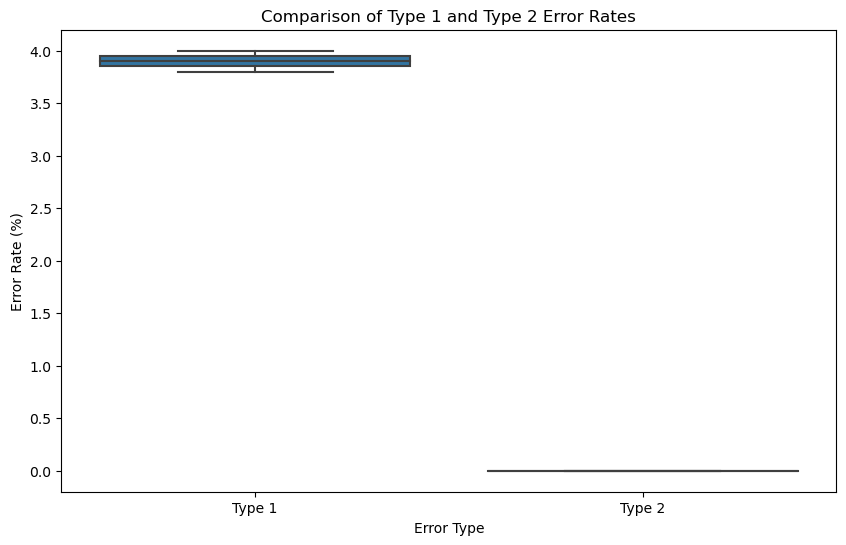

In [29]:
data = {'Variable': [], 'Error Rate (%)': [], 'Error Type': []}
for var, errors in bberror_rates.items():
    for error_type, rate in errors.items():
        data['Variable'].append(var)
        data['Error Rate (%)'].append(rate)
        data['Error Type'].append('Type 1' if 'Type 1' in error_type else 'Type 2')

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Error Type', y='Error Rate (%)', data=df)
plt.title('Comparison of Type 1 and Type 2 Error Rates')
plt.xlabel('Error Type')
plt.ylabel('Error Rate (%)')
plt.show()

In [30]:
bbnonsignificant_vars

['z1', 'z3']

### Bootstraping

In [31]:
X_with_constant = sm.add_constant(X[selected_feature])
initial_model = sm.OLS(y, X_with_constant).fit()
residuals = y - initial_model.predict(X_with_constant)

n_bootstraps = 1000
feature_selection_matrix = pd.DataFrame(0, index=np.arange(n_bootstraps), columns=X.columns)

for i in range(n_bootstraps):
    # Sample residuals and generate new y
    sampled_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
    y_new = initial_model.predict(X_with_constant) + sampled_residuals
    
    # Perform backward elimination on the new dataset
    selected_features, _ = backward_elimination(X, y_new)
    
    # Record the selected features
    feature_selection_matrix.loc[i, selected_features] = 1

# Calculate Type 1 Error for non-significant variables
non_initial_features_list = list(non_initial_features)
type1_error = feature_selection_matrix[non_initial_features].mean()

# Calculate Type 2 Error for significant variables
selected_features_backward_list = list(selected_feature)
type2_error = 1 - feature_selection_matrix[selected_features_backward_list].mean()

print("Type 1 Error Rate for Non-Significant Variables:", type1_error)
print("Type 2 Error Rate for Significant Variables:", type2_error)

Type 1 Error Rate for Non-Significant Variables: Series([], dtype: float64)
Type 2 Error Rate for Significant Variables: x1    0.000
x2    0.000
x3    0.000
x4    0.000
x5    0.000
z1    0.292
z2    0.033
z3    0.023
z4    0.006
dtype: float64


C:\Users\aneek\AppData\Local\Temp\ipykernel_18216\449858079.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  type1_error = feature_selection_matrix[non_initial_features].mean()


### Stepwise Selection

In [32]:
import pandas as pd
import statsmodels.api as sm

def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included, model

# Usage
selected_features, ss_model = stepwise_selection(X_train, y_train, initial_list=["z1"])
print("Selected Features:", selected_features)


Add  x1                             with p-value 0.0
Drop z1                             with p-value 0.0999294
Add  x3                             with p-value 0.0
Add  x4                             with p-value 0.0
Add  x2                             with p-value 0.0
Add  x5                             with p-value 0.0
Add  z4                             with p-value 4.23332e-05
Add  z2                             with p-value 0.000742256
Add  z3                             with p-value 0.00382916
Selected Features: ['x1', 'x3', 'x4', 'x2', 'x5', 'z4', 'z2', 'z3']


In [33]:
ss_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                 2.728e+05
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:22:46   Log-Likelihood:                -57919.
No. Observations:               80000   AIC:                         1.159e+05
Df Residuals:                   79991   BIC:                         1.159e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.860      0.390      -0.002       0.005
x1             2.0012      0.025     79.519      0.000       1.952       2.051
x3             0.9900      0.018     54.273      0.000       0.954       1.026
x4             0.5058      0.009     57.391      0.000       0.488       0.523
x2             1.5083      0.018     83.132      0.000       1.473       1.544
x5             0.5082      0.009     57.685      0.000       0.491       0.525
z4             0.0126      0.003      4.109      0.000       0.007       0.019
z2             0.0103      0.003      3.368      0.001       0.004       0.016
z3             0.0088      0.003      2.892      0.004       0.003       0.015
==============================================================================
Omnibus:                        0.787   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.675   Jarque-Bera (JB):                0.798
Skew:                          -0.006   Prob(JB):                        0.671
Kurtosis:                       2.991   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Permutation Test for Stepwise Selection

In [34]:
# Identifying significant and non-significant variables based on stepwise selection
threshold = 0.01
coefficients = ss_model.params[1:]  # Exclude intercept

stepwise_significant_vars = coefficients[abs(coefficients) > threshold].index.tolist()
stepwise_nonsignificant_vars = coefficients[abs(coefficients) <= threshold].index.tolist()

# Initialize error counters
type_1_errors = {var: 0 for var in stepwise_nonsignificant_vars}
type_2_errors = {var: 0 for var in stepwise_significant_vars}
n_permutations = 1000

# Perform the restricted permutation test
for _ in range(n_permutations):
    # Permute the non-significant component
    X_permuted = X[stepwise_nonsignificant_vars].sample(frac=1).reset_index(drop=True)
    X_combined = pd.concat([X[stepwise_significant_vars], X_permuted], axis=1)
    
    # Refit using stepwise selection on the combined dataset
    permuted_selected_features, _ = stepwise_selection(X_combined, y)
    
    # Update error counts based on permutation results
    for var in stepwise_nonsignificant_vars:
        if var in permuted_selected_features:
            type_1_errors[var] += 1  # False positive
    for var in stepwise_significant_vars:
        if var not in permuted_selected_features:
            type_2_errors[var] += 1  # False negative

# Calculate error rates
ss_error_rates = {}
for var in stepwise_nonsignificant_vars:
    ss_error_rates[var] = {'Type 1 Error Rate (%)': type_1_errors[var] / n_permutations * 100}
for var in stepwise_significant_vars:
    ss_error_rates[var] = {'Type 2 Error Rate (%)': type_2_errors[var] / n_permutations * 100}

ss_error_rates

Add  x1                             with p-value 0.0
Add  x3                             with p-value 0.0
Add  x4                             with p-value 0.0
Add  x2                             with p-value 0.0
Add  x5                             with p-value 0.0
Add  z4                             with p-value 1.16448e-05
Add  z2                             with p-value 9.78679e-05
Add  x1                             with p-value 0.0
Add  x3                             with p-value 0.0
Add  x4                             with p-value 0.0
Add  x2                             with p-value 0.0
Add  x5                             with p-value 0.0
Add  z4                             with p-value 1.16448e-05
Add  z2                             with p-value 9.78679e-05
Add  x1                             with p-value 0.0
Add  x3                             with p-value 0.0
Add  x4                             with p-value 0.0
Add  x2                             with p-value 0.0
Add  x5       

{'z3': {'Type 1 Error Rate (%)': 0.3},
 'x1': {'Type 2 Error Rate (%)': 0.0},
 'x3': {'Type 2 Error Rate (%)': 0.0},
 'x4': {'Type 2 Error Rate (%)': 0.0},
 'x2': {'Type 2 Error Rate (%)': 0.0},
 'x5': {'Type 2 Error Rate (%)': 0.0},
 'z4': {'Type 2 Error Rate (%)': 0.0},
 'z2': {'Type 2 Error Rate (%)': 0.0}}

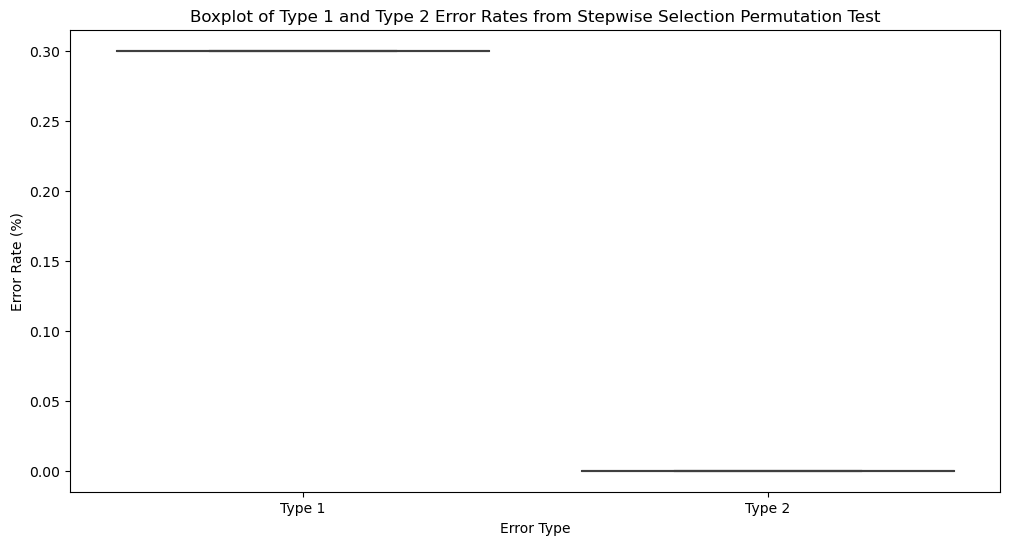

In [35]:
# Convert the error rates dictionary to a DataFrame for easier plotting
data = {
    "Variable": [],
    "Error Rate (%)": [],
    "Error Type": []
}

for var, rate in ss_error_rates.items():
    if rate.get('Type 1 Error Rate (%)') is not None:
        data["Variable"].append(var)
        data["Error Rate (%)"].append(rate['Type 1 Error Rate (%)'])
        data["Error Type"].append("Type 1")
    if rate.get('Type 2 Error Rate (%)') is not None:
        data["Variable"].append(var)
        data["Error Rate (%)"].append(rate['Type 2 Error Rate (%)'])
        data["Error Type"].append("Type 2")

df_errors = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(x="Error Type", y="Error Rate (%)", data=df_errors)
plt.title('Boxplot of Type 1 and Type 2 Error Rates from Stepwise Selection Permutation Test')
plt.show()

### Bootstrapping

In [36]:
np.random.seed(42)  # For reproducibility
n_bootstraps = 100  # Number of bootstrap samples
n_features = X_train.shape[1]

# Placeholder for recording feature selection across bootstrap samples
bootstrap_selection = np.zeros((n_bootstraps, n_features), dtype=bool)

# Initial model fitting - assuming a simple linear model here for demonstration
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
initial_residuals = y_train - model.predict(sm.add_constant(X_train))

# Simulate stepwise selection for demonstration
# In practice, replace this with an actual stepwise selection method
initial_selection = model.pvalues < 0.05  # Assuming variables with p < 0.05 are selected

for i in range(n_bootstraps):
    # Sample residuals and create a new bootstrap target
    sampled_residuals = np.random.choice(initial_residuals, size=len(initial_residuals), replace=True)
    y_bootstrap = model.predict(sm.add_constant(X_train)) + sampled_residuals
    
    # Refit the model on the bootstrap sample
    # In practice, this should be replaced with a stepwise selection process
    bootstrap_model = sm.OLS(y_bootstrap, sm.add_constant(X_train)).fit()
    bootstrap_selection[i, :] = bootstrap_model.pvalues[1:] < 0.05  # Exclude intercept

# Calculate Type 1 and Type 2 errors
type_1_errors = np.sum(bootstrap_selection[:, ~initial_selection[1:]], axis=0) / n_bootstraps * 100 # False positives
type_2_errors = np.sum(~bootstrap_selection[:, initial_selection[1:]], axis=0) / n_bootstraps * 100 # False negatives

# Variable names for reference
variable_names = X_train.columns

# Mapping Type 1 and Type 2 error rates to their variable names
type_1_error_rates = {variable_names[i]: rate for i, rate in enumerate(type_1_errors) if ~initial_selection[1:][i]}
type_2_error_rates = {variable_names[i]: rate for i, rate in enumerate(type_2_errors) if initial_selection[1:][i]}

print("Type 1 Error Rates by Variable:")
for var, rate in type_1_error_rates.items():
    print(f"{var}: {rate:}")

print("\nType 2 Error Rates by Variable:")
for var, rate in type_2_error_rates.items():
    print(f"{var}: {rate:}")


Type 1 Error Rates by Variable:

Type 2 Error Rates by Variable:
x1: 0.0
x2: 0.0
x3: 0.0
x4: 0.0
x5: 0.0
z1: 30.0
z2: 8.0
z3: 11.0
z4: 1.0


In [37]:
bootstrap_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                 2.422e+05
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:35:47   Log-Likelihood:                -57931.
No. Observations:               80000   AIC:                         1.159e+05
Df Residuals:                   79990   BIC:                         1.160e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -1.104      0.270      -0.005       0.002
x1             1.9705      0.025     78.287      0.000       1.921       2.020
x2             1.5383      0.018     84.773      0.000       1.503       1.574
x3             0.9870      0.018     54.096      0.000       0.951       1.023
x4             0.5107      0.009     57.942      0.000       0.493       0.528
x5             0.5113      0.009     58.036      0.000       0.494       0.529
z1             0.0076      0.003      2.502      0.012       0.002       0.014
z2             0.0102      0.003      3.344      0.001       0.004       0.016
z3             0.0105      0.003      3.425      0.001       0.004       0.016
z4             0.0178      0.003      5.818      0.000       0.012       0.024
==============================================================================
Omnibus:                        1.390   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                1.397
Skew:                          -0.005   Prob(JB):                        0.497
Kurtosis:                       2.982   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Data Analysis

In [38]:
data = {
    'Method': [],
    'Variable': [],
    'Significance': []  # 1 for significant, 0 for non-significant
}

# Populate the data dictionary
methods = {
    'LASSO': {'significant': ['x1', 'x2', 'x3', 'x4', 'x5'], 'nonsignificant': ['z1', 'z2', 'z3', 'z4']},
    'Forward Selection': {'significant': ['x1', 'x2', 'x3', 'x4', 'x5', 'z2', 'z3', 'z4'], 'nonsignificant': ['z1']},
    'Backward Selection': {'significant': ['x1', 'x2', 'x3', 'x4', 'x5', 'z2', 'z4'], 'nonsignificant': ['z1', 'z3']},
    'Stepwise Selection': {'significant': ['x1', 'x2', 'x3', 'x4', 'x5', 'z2', 'z4'], 'nonsignificant': ['z3']}
}

for method, vars in methods.items():
    for var in vars['significant']:
        data['Method'].append(method)
        data['Variable'].append(var)
        data['Significance'].append(1)
    for var in vars['nonsignificant']:
        data['Method'].append(method)
        data['Variable'].append(var)
        data['Significance'].append(0)

df = pd.DataFrame(data)


C:\Users\aneek\AppData\Local\Temp\ipykernel_18216\3040680637.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Variable', y='Significance', hue='Method', data=df, ci=None, palette='rainbow')


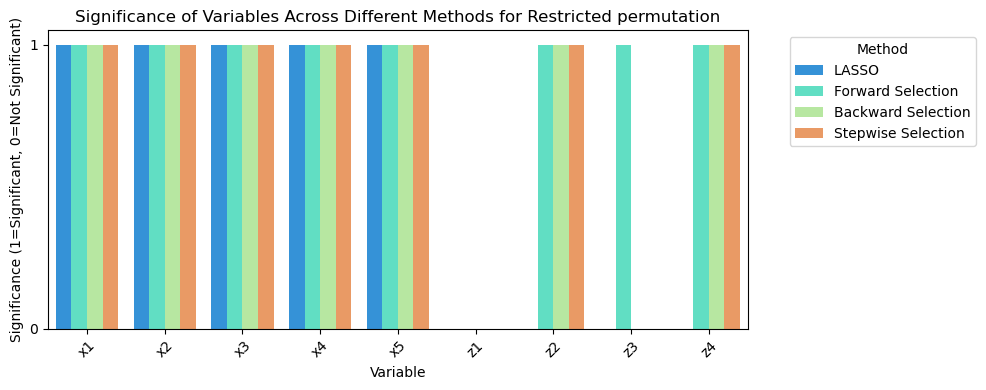

In [39]:
# Since we can't directly plot a boxplot, we'll use a bar plot to show presence/absence visually
plt.figure(figsize=(10, 4))
sns.barplot(x='Variable', y='Significance', hue='Method', data=df, ci=None, palette='rainbow')

plt.title('Significance of Variables Across Different Methods for Restricted permutation')
plt.ylabel('Significance (1=Significant, 0=Not Significant)')
plt.xlabel('Variable')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yticks([0, 1])

# Adjustments for better readability
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()